In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from random import random
import json, os.path, pickle
import sys, time
from pathlib import Path
print(f"running python {sys.version}")

# condtional printing untility, only prints important messages
global verbosity
verbosity = 5
def pp(importance, message):
    if importance > 10-verbosity:
        print(message)



running python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [3]:
# Configure testing variable based on fact that my kids windows pcs are more powerfult than my cheapo linux box
from sys import platform
testing = platform == 'linux'
print (f"we are {'' if testing else 'not '}on a testing computer")

we are on a testing computer


Testing the learning curve mathematics based on three parameters.


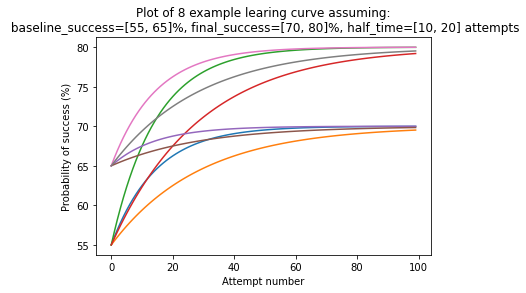

In [4]:
print("Testing the learning curve mathematics based on three parameters.")

def success_p(attempt, baseline_success, final_success, half_time):
    failure_risk = 0.5**(attempt/half_time) # in range 0 to 1
    return final_success - failure_risk *(final_success - baseline_success)

def plot_example_learning_curves():
    bs = [55, 65] # percent
    fs =[70,80] # percent
    ht = [10, 20]
    fig, ax = plt.subplots()
    for baseline_success in bs:
        for final_success in fs: # percent
            for half_time in ht: # cases
                x = np.array(range(0, 100))  
                y = success_p(attempt = x, baseline_success = baseline_success, final_success = final_success, half_time = half_time)
                plt.plot(x, y)  
    plt.title(f"Plot of {len(bs)*len(fs)*len(ht)} example learing curve assuming:\n baseline_success={bs}%, final_success={fs}%, half_time={ht} attempts")
    ax.set_ylabel('Probability of success (%)')
    ax.set_xlabel('Attempt number')
    plt.show()  

plot_example_learning_curves()

In [5]:
##
## Create a population of learning curves
## (as three seperate arrays of the defining parameters)
## 


"""
Make mock curves as defined by three lists of defining parameters:
* baseline success probablity (ie how well the student will do on first ever attempt)
* final sussess probability (ie how well this stuedent will eventually become)
* number of attempts to achieve half the improvement from baseline to final proficency
"""
def generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000):
    #baseline_success_p = 1/(1+np.random.exponential(odds_of_failure,n))
    # see https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af
    baseline_success_p = np.random.beta(baseline_alpha, baseline_beta,n)
    failure_p = 1-baseline_success_p # baseline risk of failure 
    final_success_p = 1-(failure_p * (1-fall_in_failure_rate*np.random.random(n)))
    attempts_to_half_improvement = np.random.rayleigh(half_time_mean,n)
    return {"bsp": baseline_success_p, "fsp": final_success_p, "athi": attempts_to_half_improvement}

""" 
Describe a set of student curves, and optionally plot.
Return a dictionary of values.                      
"""
def describe_student_curves(sc, meta, chattiness=1):
    pp(chattiness, f"""      
    baseline_success_p = {sc['bsp'].mean():0.2f} (sd: {sc['bsp'].std():0.2f})
    final_success_p = {sc['fsp'].mean():0.2f} (sd: {sc['fsp'].std():0.2f})
    attempts_to_half_improvement = {sc['athi'].mean():0.2f} (sd: {sc['athi'].std():0.2f})
    """)    
    return {
      **meta,
      "baseline_success_p": sc['bsp'].mean(),
      "baseline_success_p_sd": sc['bsp'].std(),     
      "final_success_p": sc['fsp'].mean(), 
      "final_success_p_sd": sc['fsp'].std(),
      "attempts_to_half_improvement": sc['athi'].mean(),
      "attempts_to_half_improvement_sd": sc['athi'].std(),
      "key": f"{sc['bsp'].mean():0.2f}_{sc['bsp'].std():0.2f}_{sc['fsp'].mean():0.2f}_{sc['fsp'].std():0.2f}_{sc['athi'].mean():0.2f}_{sc['athi'].std():0.2f}"
        }

def plot_student_curve(sc):
    n = len(sc['bsp'])
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 2))
    count, bins, ignored = ax0.hist(sc['bsp'], bins=100, density=True, alpha=0.6, label="Baseline")
    count, bins, ignored = ax0.hist(sc['fsp'], bins=100, density=True, alpha=0.6, range=(0,1), label="Final")
    ax0.axis((0,1,0,n/200))
    ax0.set_title("Distribution of student's success probability")
    ax0.set_xlabel('Probability of success')
    ax0.legend()
    ax0.set(yticklabels=[]) 
    count, bins, ignored = ax1.hist(sc['athi'], bins=100, density=False)
    ax1.set_title("Distribution of student's attempts\nto make half ultimate improvement")
    ax1.set_xlabel('Attempt number')
    ax1.set(yticklabels=[]) 
    fig.tight_layout()
    plt.show()

""" 
Implement the student curve by calculating the probability of success at a given attempt. 
""" 
def student_p(student_id, attempt, sc):
    failure_risk = 0.5**(attempt/sc['athi'][student_id]) # in range 0 to 1
    return sc['fsp'][student_id] - failure_risk *(sc['fsp'][student_id] - sc['bsp'][student_id])
        
"""
create a 2d array of student success probabilities
"""
def student_attempt_success(sc, attempts=20):
    n = len(sc['bsp'])
    students = np.array(range(0, n))
    attempts = np.array(range(0, attempts))
    # make a matrix from the above two arrays
    return student_p(students[:,np.newaxis],attempts[np.newaxis,:],sc)    

def succeeded(p, success_relative_increase):
    random_roll = np.random.random(p.shape)
    modified_success = 1 - ((1-p)/(1+success_relative_increase))
    pp(7, f"P initial: {p.mean():0.3}  P after adjustment: {modified_success.mean():0.3}; dice: {random_roll.mean():0.3}")
    return random_roll < modified_success

def create_mock_students(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000, chattiness = 5):
    # baseline "beta" curve defining initial success rate
    sc = generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n)
    sac = student_attempt_success(sc, attempts=20)
    pp(chattiness, f"Generated attempt success curves for {n} students.")
    return sc, sac

loaded student_sets.pickle
'variable' (2000 students)


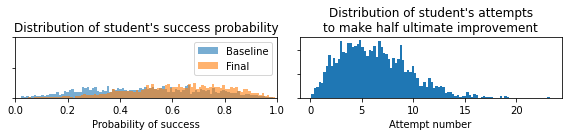

'uniform' (2000 students)


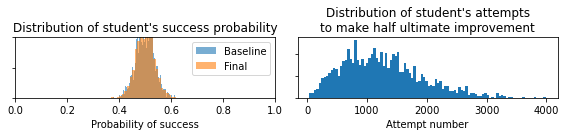

'initial' (2000 students)


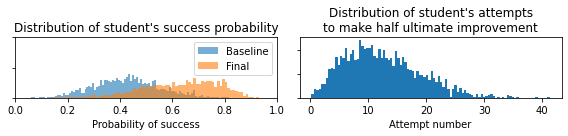

'second' (2000 students)


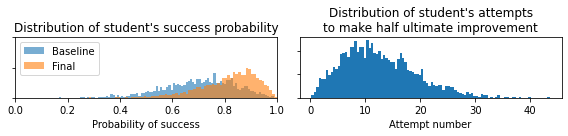

,baseline_alpha,baseline_beta,fall_in_failure_rate,half_time_mean,baseline_success_p,baseline_success_p_sd,final_success_p,final_success_p_sd,attempts_to_half_improvement,attempts_to_half_improvement_sd,key,sc,sac
variable,2,2,0.50,5,0.499557,0.221390,0.624239,0.183931,6.265773,3.319677,0.50_0.22_0.62_0.18_6.27_3.32,"{'bsp': [0.45914679633914146, 0.41697799738208...","[[0.45914679633914146, 0.48021341207637047, 0...."
uniform,100,100,0.00,1000,0.499784,0.035511,0.499784,0.035511,1255.292396,655.457881,0.50_0.04_0.50_0.04_1255.29_655.46,"{'bsp': [0.48490432507156345, 0.42329162479280...","[[0.48490432507156345, 0.48490432507156345, 0...."
initial,6,8,0.70,10,0.427198,0.126695,0.629988,0.142840,12.453025,6.512537,0.43_0.13_0.63_0.14_12.45_6.51,"{'bsp': [0.44079158643145894, 0.46385496642229...","[[0.44079158643145894, 0.4433837719001402, 0.4..."
second,7,3,0.75,10,0.702940,0.134076,0.815079,0.108070,12.583497,6.689264,0.70_0.13_0.82_0.11_12.58_6.69,"{'bsp': [0.7184879706390098, 0.620722833702979...","[[0.7184879706390098, 0.7258838691336087, 0.73..."


In [6]:
"""
Create and cache a set of student curves
"""
def make_student_sets(n=100, chattiness=1):
    metas = {
        "variable": {
            "baseline_alpha": 2,
            "baseline_beta": 2,
            "fall_in_failure_rate": 0.5, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 5, # how quickly to students learn?
        },
        "uniform": {
            "baseline_alpha": 100,
            "baseline_beta": 100,
            "fall_in_failure_rate": 0, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 1000, # how quickly to students learn?
        },
        "initial": {
            "baseline_alpha": 6,
            "baseline_beta": 8,
            "fall_in_failure_rate": .7, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 10, # how quickly to students learn?
        },
        "second": {
            "baseline_alpha": 7,
            "baseline_beta": 3,
            "fall_in_failure_rate": .75, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 10, # how quickly to students learn?
        }
    }
    student_sets = {}
    for name, meta in metas.items():
        print(f"Making {name} {n}")
        sc, sac = create_mock_students(
            baseline_alpha = meta['baseline_alpha'], 
            baseline_beta = meta['baseline_beta'],
            fall_in_failure_rate = meta['fall_in_failure_rate'], # how much do they improve (or does their failure rate drop)
            half_time_mean = meta['half_time_mean'], # how quickly to students learn?
            chattiness=chattiness, n = n)   
        final_meta = describe_student_curves(sc, meta)
        student_sets[name] = {**final_meta, "sc":sc,"sac":sac}
    return student_sets


def load_student_sets(testing=True, student_sets_file_prefix=False, overwrite=False):
    if testing:
        student_sets = pd.DataFrame.from_dict(make_student_sets(chattiness = 10, n=2000), orient='index')
    else:
        pickle_file = f"{student_sets_file_prefix}.pickle"
        if os.path.isfile(pickle_file) and not overwrite:
            with open(pickle_file, 'rb') as f:
                student_sets = pickle.load(f)
            pp(8, f"loaded {pickle_file}")
        else:
            pp(8, "generating")
            student_sets = pd.DataFrame.from_dict(make_student_sets(n=2000), orient='index')
            with open(pickle_file, 'wb') as f:
                pickle.dump(student_sets, f)
            pp(8, f"saved {pickle_file}")
    return student_sets

def plot_student_curves(student_sets):
    for set_name, meta in student_sets.iterrows():
        print(f"'{set_name}' ({len(meta['sc']['bsp'])} students)")
        plot_student_curve(meta['sc'])

student_sets_file_prefix = 'student_sets'
student_sets = load_student_sets(student_sets_file_prefix=student_sets_file_prefix, testing=False)
plot_student_curves(student_sets)
student_sets

In [7]:
def generate_trial_data(subject_n, attempt_n, trials, groups, sac):
    attempt_data = []
    participant_data = []
    trial_data = []
    totals = {}
    attempts_per_group = trials*subject_n*attempt_n
    print(f"{attempts_per_group} total attempts per group")
    for trial in range(trials):
        pp(7,f"=======\ntrial {trial}")
        for group, success_relative_increase in groups.items():
            pp(6, f"group: {group}")
            students = sac[np.random.choice(len(sac), subject_n, replace=True), :attempt_n]
            pp(5,students)
            result = succeeded(students,success_relative_increase)
            pp(6, f"result: {result}")
            pp(6, f"{group} success: {result.sum()}/{(result.size)} ({100*result.sum()/(result.size):3.1f}%)" )
            totals[group] = totals.get(group, 0) + result.sum()
            rec = {'trial': trial, 'group': group, "result": result.sum()}
            trial_data.append(rec)
            for p in range(subject_n):
                participant_results = result[p]
                rec["p"] = f"{group}{p}"
                prec = {**rec, "result": participant_results.sum()}
                pp(1,prec)
                participant_data.append(prec)
                for i in range(len(participant_results)):
                    irec = {**rec, "pint": p, "i": i, "result": 1 if participant_results[i] else 0}
                    pp(1,irec)
                    attempt_data.append(irec)

    pp(5, f"totals: {totals}")
    td = pd.DataFrame(trial_data)
    partd = pd.DataFrame(participant_data)
    ad = pd.DataFrame(attempt_data)
    return td, partd, ad, totals

In [8]:
def trial_plots(td, partd, ad, box=False):
    if box:
        whisker = 5
        ax = sns.boxplot(x="group", y="result", data=td, whis=[whisker, 100-whisker])
        title_msg =  " (Whiskers at {whisker}% and {100-whisker}%)"
    else:
        title_msg =  ""
    #ax = sns.swarmplot(x="group", y="result", data=td)
    ax = sns.violinplot(x="group", y="result", data=td)
    ax.set_ylabel('Successes (count)')
    ax.set_xlabel('Group')
    plt.title(f"Successful attempts in each arm of {ad.trial.max()+1} trials of {int(len(partd)/len(td))} students, each having {int(len(ad)/len(partd))} attempts.{title_msg}")
    plt.show()
    pd.crosstab(ad.result, ad.i).plot(kind='bar')
    plt.title("Success per iteration")
    plt.show()
    ad.groupby(['group', 'i']).result.sum().plot(stacked=True,kind='bar')
    plt.title("Success per iteration")
    plt.show()
    
def test_trial_generation(sac, groups, subject_n = 5, attempt_n = 5, trials = 1000):
    global verbosity
    verbosity = 10 if trials < 3 else 6 if trials < 10 else 2  # range of 0-10
    print(f"verbosity: {verbosity}")
    print(f"{trials} trials sampling {subject_n} for each of {len(groups)} groups out of {sac.shape[0]} students, each having {attempt_n} attempts")
    td, partd, ad, totals = generate_trial_data(subject_n, attempt_n, trials, groups, sac)

    def sumarise_trial(totals, attempts_per_group):
        results_percents = {}
        for group, result in totals.items():
            print(group, result)
            results_percents[group] = 100*result/attempts_per_group
        print(results_percents)
    sumarise_trial(totals, attempts_per_group=subject_n*attempt_n*trials)

    return td, partd, ad

# groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "nodif": 0}
#td, partd, ad = test_trial_generation(sac, groups)

In [41]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols, gee, mixedlm
#from statsmodels.formula.api import gee
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

"""
see: https://www.statsmodels.org/dev/_modules/statsmodels/genmod/cov_struct.html#CovStruct 
"""
def fit_models(ad, trials_to_test, tests):
    outcomes = {}
    for trial in trials_to_test:
        if not trial % 100:
            print(">",end='')
        pp(5, f"#### trial: {trial} #####")
        itd = ad.query(f"trial == {trial}") # individual trial data
        c = itd[['group','result']].groupby("group").sum().reset_index().set_index("group")
        print('c', c)
        res = False # reset to prevent accidental carryover
        for model in tests:
            pp(5, f"#### {model}")
            if model == 'ols':
                res = ols('result ~ C(group)+i', data=itd).fit()
            elif model == 'geeB':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'geeBI':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'geeBIs': # drop the "i" variable (which tracks attempt number)
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'gee':
                fam = sm.families.Poisson()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'bbm':
                #fixme  - see:
                # https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.PoissonBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.PoissonBayesMixedGLM
                mod = BinomialBayesMixedGLM("result ~ C(group)+i", "p", itd)
                res = mod.fit()
            elif model == 'mlm':
                mod = mixedlm("result ~ C(group)+i", itd, groups=itd["p"])
                res = mod.fit()
            elif model == 'mlms':
                mod = mixedlm("result ~ C(group)", itd, groups=itd["p"])
                res = mod.fit()

            else:
                raise Exception(f"bad model: {model}")
            pp(3, res.summary())
            p=res.pvalues[1]
            outcome = 'ns' if p > 0.05 else 'wrong' if c['result'][0] > c['result'][1] else 'sig' if p> 0.01 else 'vsig'
            pp(6, f"******************p = {p:0.6f} -{outcome}")
            key = f"{model}{outcome}"
            if outcomes.get(key, -1) == -1:
                outcomes.update({f"{model}wrong":0,f"{model}ns":0,f"{model}sig":0,f"{model}vsig":0,f"{model}p":[]})
            outcomes[key] += 1
            outcomes[f"{model}p"].append(p)

    return(outcomes)


In [22]:
def read_trials(trial_cache_dir):
    pp(10, f'reading {trial_cache_dir}')
    ad = pd.read_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd = pd.read_csv(f"{trial_cache_dir}/partd.csv")
    td = pd.read_csv(f"{trial_cache_dir}/td.csv")
    return td, partd, ad
    pp(10, 'done')

def write_trials(td, partd, ad, trial_cache_dir, overwrite=False):
    Path(trial_cache_dir).mkdir(parents=True, exist_ok=not overwrite)
    pp(10, f'writing {trial_cache_dir}')
    ad.to_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd.to_csv(f"{trial_cache_dir}/partd.csv")
    td.to_csv(f"{trial_cache_dir}/td.csv")
    pp(10, 'done')

def get_trials(student_sets, trialn = 100, subject_n = 200, attempt_n = 20):
    trials = {}
    for student_set_name, student_meta in student_sets.iterrows():
        print(f"'{student_set_name}' ({len(student_meta['sc']['bsp'])} students)")
        trial_cache_dir = f"trial_cache/{student_set_name}_{trialn}_{subject_n}_{attempt_n}"
        if os.path.isdir(trial_cache_dir):
            td, partd, ad = read_trials(trial_cache_dir)
        else:
            print(f"generating fresh trial data as `{trial_cache_dir}` does not exist")
            print(f"using '{student_set_name}' ({len(student_meta['sc']['bsp'])} students)")
            groups = {"control": 0, "interventionA":0.1, "interventionB":0.2,
                      "interventionBa":0.4, "interventionBb":0.5,
                      "interventionC":0.6, "interventionD": 0.8, "nodif": 0}
            td, partd, ad = test_trial_generation(student_meta['sac'], groups, subject_n = subject_n, attempt_n = attempt_n, trials = trialn)
            write_trials(td, partd, ad, trial_cache_dir, overwrite=False)
        trials[student_set_name] = {"td":td,"partd":partd,"ad":ad}
    return trials

## add some more arms to the trials and save in new directory
"""
if addintervention:
    new_trial_cache_dir = f"{trial_cache_dir}e"
    groups = {"interventionBa":0.4, "interventionBb":0.5}
    pop_type = 'tight'
"""                 
def extend_trial(td, partd, ad, groups, new_trial_cache_dir, subject_n = 200, attempt_n = 20):
    print("generating extra trial data")
    trial_cache_dir = f"trial_cache_{pop_type}{trialn}"
    tde, partde, ade = test_trial_generation(sac, groups, subject_n = subject_n, attempt_n = attempt_n, trials = trialn)
    td = td.append(tde)
    ad = ad.append(ade)
    partd = partd.append(partd)
    write_trials(td, partd, ad, new_trial_cache_dir)

In [11]:
if testing:
    trials = get_trials(student_sets, trialn = 10, subject_n = 10, attempt_n = 5)     
else:
    trials = get_trials(student_sets, trialn = 100, subject_n = 400, attempt_n = 20)     

'variable' (2000 students)
reading trial_cache/variable_10_10_5
'uniform' (2000 students)
reading trial_cache/uniform_10_10_5
'initial' (2000 students)
reading trial_cache/initial_10_10_5
'second' (2000 students)
reading trial_cache/second_10_10_5


Summary of trials done on different student populations
variable


result           
                 mean  sum count
group                           
control         0.490  245   500
interventionA   0.586  293   500
interventionB   0.642  321   500
interventionBa  0.670  335   500
interventionBb  0.744  372   500
interventionC   0.694  347   500
interventionD   0.748  374   500
nodif           0.538  269   500

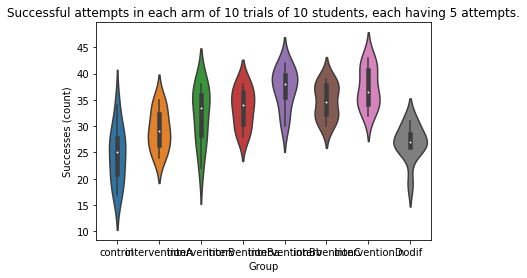

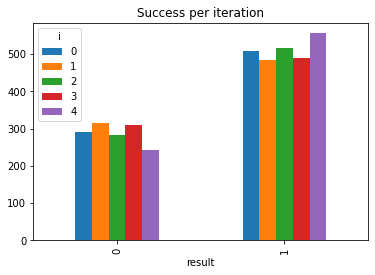

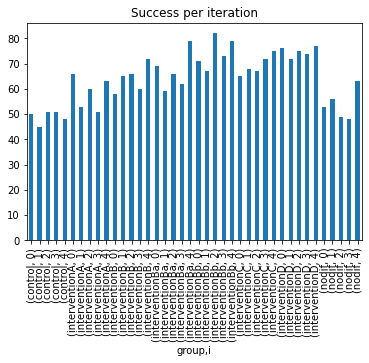

uniform


result           
                 mean  sum count
group                           
control         0.502  251   500
interventionA   0.574  287   500
interventionB   0.582  291   500
interventionBa  0.670  335   500
interventionBb  0.658  329   500
interventionC   0.710  355   500
interventionD   0.712  356   500
nodif           0.494  247   500

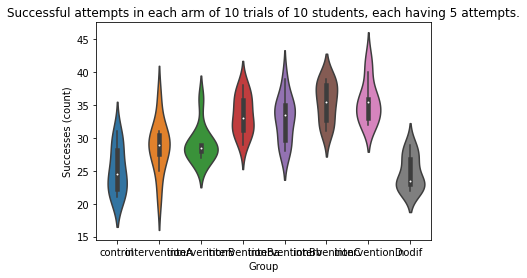

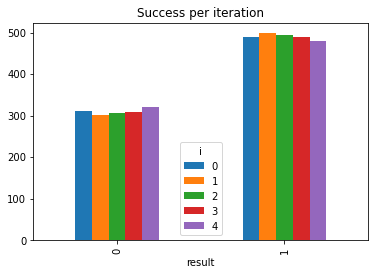

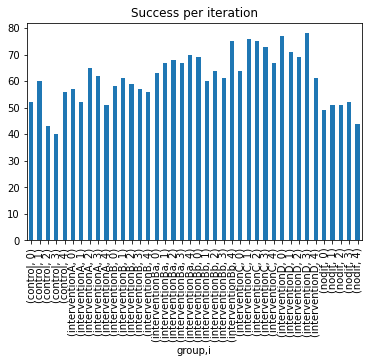

initial


result           
                 mean  sum count
group                           
control         0.474  237   500
interventionA   0.538  269   500
interventionB   0.560  280   500
interventionBa  0.624  312   500
interventionBb  0.642  321   500
interventionC   0.692  346   500
interventionD   0.700  350   500
nodif           0.460  230   500

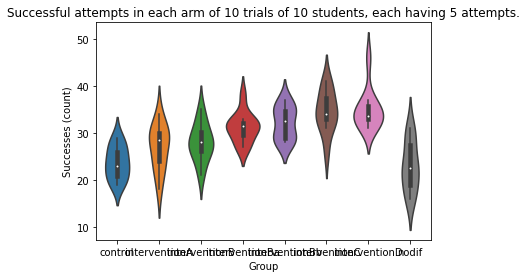

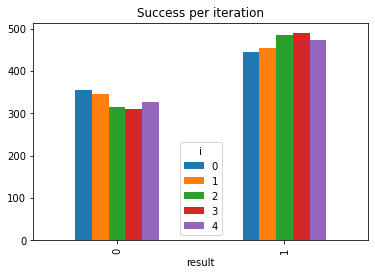

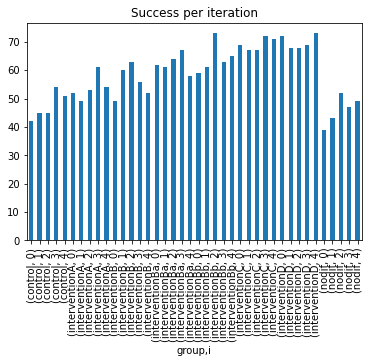

second


result           
                 mean  sum count
group                           
control         0.700  350   500
interventionA   0.770  385   500
interventionB   0.788  394   500
interventionBa  0.796  398   500
interventionBb  0.804  402   500
interventionC   0.806  403   500
interventionD   0.846  423   500
nodif           0.692  346   500

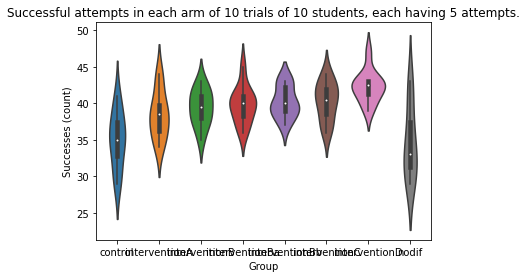

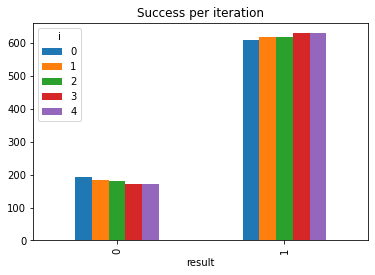

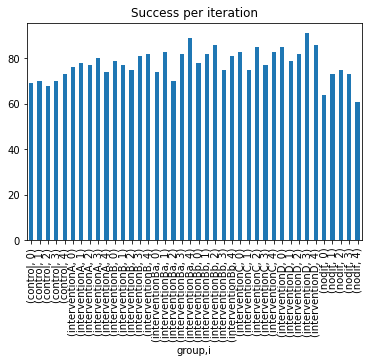

In [12]:
print("Summary of trials done on different student populations")
for student_set, trial in trials.items():
    ad = trial['ad']
    group_totals = ad[['group','result']].groupby('group').agg(['mean', 'sum', 'count'])
    print(student_set)
    display(group_totals)
    trial_plots(trial['td'], trial['partd'], trial['ad'])

In [42]:
# This is essentiall a wrapper around fit_models() to enable caching
def run_sym(student_set, attempt_data, pairs, tests, trials_to_test, spg, aps,
    run_key="A",cache_path="cache/"):
    print('.', end='')
    global verbosity
    verbosity = 6 if trials_to_test < 5 else 4
    sym_results = []
    for comparision, pair in pairs.items():
        for students_per_group in spg: #[5, 10]:
            for attempts_per_student in aps: #[5,10]:
                # attempt to read from a cache file
                key = f"{run_key}.{trials_to_test}{comparision}.{students_per_group}.{attempts_per_student}"
                file = f"{cache_path}/{student_set}/{key}.json"
                if os.path.isfile(file):
                    with open(file) as f:
                        rec = json.load(f)
                    pp(8, f"loaded {file}")
                else:
                    query = f"group == {pair} and pint < {students_per_group} and i < {attempts_per_student}"
                    trial_data = attempt_data.query(query)
                    pp(10, f"`{query}` ({len(trial_data)} total attempts)")
                    run_results = fit_models(ad=trial_data, trials_to_test=range(trials_to_test), tests=tests)
                    pp(10, f"run_results: {run_results}")
                    rec = {"student_set": student_set,
                         "comparision":comparision, 
                         "students_per_group": students_per_group, 
                         "attempts_per_student": attempts_per_student,
                         "groupA": pair[0], "groupB": pair[1], 
                         "total_attempts": len(trial_data),
                         "trials": trials_to_test,
                         **run_results,
                         'query': query, 'time':time.time()*1000,
                         'key': key}
                    Path(os.path.dirname(file)).mkdir(parents=True, exist_ok=True) # make the cache dir
                    with open(file, 'w') as f:
                        pp(8, f"saving {file}")
                        json.dump(rec, f)
                sym_results.append(rec)
    return pd.DataFrame(sym_results)

In [45]:
# Test running code
# Edit the code below to loop over different simulations
def run_test(testing = True, phase=0):
    pairs = {'none': ['control','nodif'],
                 'vsmall': ['control','interventionA'],
                 'small': ['control','interventionB'],
                 'mod': ['control','interventionBa'],
                 'mod1': ['control','interventionBb'],
                 'big': ['control', 'interventionC'],
                 'huge': ['control', 'interventionD'],
                 'upper': [ 'interventionC', 'interventionD']
                }
    pairs = {'none': ['control','nodif'],
                 'small': ['control','interventionB'],
                 'mod': ['control','interventionBa'],
                 'mod1': ['control','interventionBb'],
                 'big': ['control', 'interventionC'],
                }

    tests = ['mlm', 'mlms', 'geeBIs','geeBI', 'gee'] #, 'bbm']
    if testing:
        students_per_group = [10]
        attempts_per_student = [5]
        trials_to_test = 2
        cache = "cache_test_t/"
    else:
        students_per_group = [75] if phase == 0 else [30, 75, 100] if phase == 1 else [20, 30, 50, 75, 100, 200, 400]
        attempts_per_student = [10] if phase < 2 else [10,20]
        trials_to_test = trials['uniform']['ad'].trial.max()+1
        cache="cache2/"

    print(f"testing {trials_to_test} trials")
    syms = [] # temporyary value replaced with a dataframe
    for student_set, trial in trials.items():
        ad = trial['ad']
        sym = run_sym(
            student_set = student_set,
            attempt_data = ad,
            pairs = pairs,
            run_key="e", tests = tests,
            trials_to_test = trials_to_test,
            spg = students_per_group,
            aps = attempts_per_student,
            #run_key="c",   tests = ['geeB','geeBI','geeBIs']
            cache_path=cache)
        # accumulate all the results into a single df
        syms = syms.append(sym) if len(syms) else sym
    return syms

In [46]:
#test3 = run_test(testing=testing)
#test4 = run_test(testing=False)
for phase in range(1 if testing else 3): # 
    print(f"phase {phase}+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    sym_run = run_test(testing=testing, phase=phase)
    outfile = f'test10a.{phase}.csv'
    sym_run.to_csv(outfile)
    print(f"saving {outfile}")
print('done')   

phase 0+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
testing 2 trials
.`group == ['control', 'nodif'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c          result
group          
control      18
nodif        31
#### mlm
******************p = 0.064490 -ns
#### mlms
******************p = 0.064490 -ns
#### geeBIs
******************p = 0.063938 -ns
#### geeBI
******************p = 0.064629 -ns
#### gee
******************p = 0.098223 -ns
#### trial: 1 #####
c          result
group          
control      21
nodif        19
#### mlm
******************p = 0.757621 -ns
#### mlms
******************p = 0.757621 -ns
#### geeBIs
******************p = 0.744872 -ns
#### geeBI
******************p = 0.744799 -ns
#### gee
******************p = 0.690099 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.06449007559693791, 0.7576207825947946], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.232743 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.231099 -ns
#### geeBIs
******************p = 0.125696 -ns
#### geeBI
******************p = 0.125193 -ns
#### gee
******************p = 0.115213 -ns
#### trial: 1 #####
c          result
group          
control      22
nodif        22
#### mlm
******************p = 1.000000 -ns
#### mlms
******************p = 1.000000 -ns
#### geeBIs
******************p = 1.000000 -ns
#### geeBI
******************p = 1.000000 -ns
#### gee
******************p = 0.961036 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.23274260984690265, 0.9999999999999991], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.23109892911852048, 0.9999999999999991], 'geeBIswrong': 0, 'geeBIsns': 2, 'geeBIssig': 0, 'geeBIsvsig': 0, 'geeBIsp': [0.12569591558537, 0.9999999999999998], 'geeBIwrong': 0, 'geeBIns': 2, 'geeBIsig': 0, 'geeBIvsig': 0, 'geeBIp': [0.1251932406986933, 0.9999999999999999], 'geewrong': 0, 'geens': 2, 'geesig': 0, 'geevsig': 0, 'g

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 1.000000 -ns
#### mlms
******************p = 1.000000 -ns
#### geeBIs
******************p = 1.000000 -ns
#### geeBI
******************p = 1.000000 -ns
#### gee
******************p = 0.997382 -ns
#### trial: 1 #####
c                result
group                
control            22
interventionB      28
#### mlm
******************p = 0.292172 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.240307 -ns
#### geeBIs
******************p = 0.271480 -ns
#### geeBI
******************p = 0.271377 -ns
#### gee
******************p = 0.282028 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [1.0, 0.2921715001712971], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.9999999999999981, 0.24030681324919212], 'geeBIswrong': 0, 'geeBIsns': 2, 'geeBIssig': 0, 'geeBIsvsig': 0, 'geeBIsp': [0.9999999999999996, 0.271480477748973], 'geeBIwrong': 0, 'geeBIns': 2, 'geeBIsig': 0, 'geeBIvsig': 0, 'geeBIp': [0.9999999999999998, 0.27137673223323333], 'geewrong': 0, 'geens': 2, 'geesig': 0, 'geevsig': 0, 'geep': [0.9973823802076109, 0.2820277241044068]}
saving cache_test_t//uniform/e.2small.10.5.json
`group == ['control', 'interventionBa'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                 result
group                 
control             29
interventionBa      32
#### mlm


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.542374 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.541839 -ns
#### geeBIs
******************p = 0.429435 -ns
#### geeBI
******************p = 0.430424 -ns
#### gee
******************p = 0.449390 -ns
#### trial: 1 #####
c                 result
group                 
control             22
interventionBa      31
#### mlm
******************p = 0.071862 -ns
#### mlms
******************p = 0.071864 -ns
#### geeBIs
******************p = 0.061325 -ns
#### geeBI


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.060399 -ns
#### gee
******************p = 0.084027 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.5423737683940963, 0.0718620724090491], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.5418393235072696, 0.07186430237750636], 'geeBIswrong': 0, 'geeBIsns': 2, 'geeBIssig': 0, 'geeBIsvsig': 0, 'geeBIsp': [0.4294349598472419, 0.06132485546702116], 'geeBIwrong': 0, 'geeBIns': 2, 'geeBIsig': 0, 'geeBIvsig': 0, 'geeBIp': [0.43042415010204826, 0.060398547314508395], 'geewrong': 0, 'geens': 2, 'geesig': 0, 'geevsig': 0, 'geep': [0.44938991606399714, 0.08402677557344436]}
saving cache_test_t//uniform/e.2mod.10.5.json
`group == ['control', 'interventionBb'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                 result
group                 
control             29
interventionBb      34
#### mlm
******************p = 0.304666 -ns
#### mlms
******************p = 0.302658 -ns
#### geeBIs
*

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.089209 -ns
#### mlms
******************p = 0.089209 -ns
#### geeBIs
******************p = 0.086459 -ns
#### geeBI
******************p = 0.086225 -ns
#### gee
******************p = 0.083620 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.30466550875397325, 0.08920880891715932], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.3026580184630344, 0.08920880977199833], 'geeBIswrong': 0, 'geeBIsns': 2, 'geeBIssig': 0, 'geeBIsvsig': 0, 'geeBIsp': [0.26233106460413536, 0.08645919732489646], 'geeBIwrong': 0, 'geeBIns': 2, 'geeBIsig': 0, 'geeBIvsig': 0, 'geeBIp': [0.26240680239802816, 0.08622508133262335], 'geewrong': 0, 'geens': 2, 'geesig': 0, 'geevsig': 0, 'geep': [0.25584335684332404, 0.0836199791955132]}
saving cache_test_t//uniform/e.2mod1.10.5.json
`group == ['control', 'interventionC'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                result
group                
control    

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.055225 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.053987 -ns
#### geeBIs
******************p = 0.003194 -vsig
#### geeBI
******************p = 0.003187 -vsig
#### gee
******************p = 0.012484 -sig
#### trial: 1 #####
c                result
group                
control            22
interventionC      31
#### mlm
******************p = 0.066775 -ns
#### mlms
******************p = 0.069543 -ns
#### geeBIs
******************p = 0.049256 -sig
#### geeBI


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.051525 -ns
#### gee
******************p = 0.074797 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.05522481502288464, 0.06677517163858267], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.05398716878360422, 0.0695429264775169], 'geeBIswrong': 0, 'geeBIsns': 0, 'geeBIssig': 1, 'geeBIsvsig': 1, 'geeBIsp': [0.003194196772001017, 0.04925594367566481], 'geeBIwrong': 0, 'geeBIns': 1, 'geeBIsig': 0, 'geeBIvsig': 1, 'geeBIp': [0.0031867480831888092, 0.05152492768322329], 'geewrong': 0, 'geens': 1, 'geesig': 1, 'geevsig': 0, 'geep': [0.012484436419905614, 0.07479681241479819]}
saving cache_test_t//uniform/e.2big.10.5.json
.`group == ['control', 'nodif'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c          result
group          
control      19
nodif        23
#### mlm
******************p = 0.532726 -ns
#### mlms
******************p = 0.532726 -ns
#### geeBIs
******************p = 0.510815 

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.874368 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


******************p = 0.874446 -ns
#### geeBIs
******************p = 0.843707 -ns
#### geeBI
******************p = 0.843770 -ns
#### gee
******************p = 0.842733 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.5327260169483594, 0.874367580731797], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.5327260175474533, 0.8744459189374075], 'geeBIswrong': 0, 'geeBIsns': 2, 'geeBIssig': 0, 'geeBIsvsig': 0, 'geeBIsp': [0.5108154136672742, 0.8437069810334192], 'geeBIwrong': 0, 'geeBIns': 2, 'geeBIsig': 0, 'geeBIvsig': 0, 'geeBIp': [0.5111307866884247, 0.8437702605750024], 'geewrong': 0, 'geens': 2, 'geesig': 0, 'geevsig': 0, 'geep': [0.5191456825792575, 0.8427332226391249]}
saving cache_test_t//initial/e.2none.10.5.json
`group == ['control', 'interventionB'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                result
group                
control            19
interventionB      35
#### mlm
************

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

******************p = 0.003859 -vsig
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.004877 -vsig
#### geeBIs
******************p = 0.010600 -sig
#### geeBI
******************p = 0.012749 -sig
#### gee
******************p = 0.015746 -sig
#### trial: 1 #####
c                 result
group                 
control             23
interventionBa      31
#### mlm
******************p = 0.129044 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.129044 -ns
#### geeBIs
******************p = 0.116471 -ns
#### geeBI
******************p = 0.116471 -ns
#### gee
******************p = 0.117173 -ns
run_results: {'mlmwrong': 0, 'mlmns': 1, 'mlmsig': 0, 'mlmvsig': 1, 'mlmp': [0.003858552787746563, 0.1290442362263419], 'mlmswrong': 0, 'mlmsns': 1, 'mlmssig': 0, 'mlmsvsig': 1, 'mlmsp': [0.004876954195409461, 0.12904383437008363], 'geeBIswrong': 0, 'geeBIsns': 1, 'geeBIssig': 1, 'geeBIsvsig': 0, 'geeBIsp': [0.010599501516879113, 0.11647103761152859], 'geeBIwrong': 0, 'geeBIns': 1, 'geeBIsig': 1, 'geeBIvsig': 0, 'geeBIp': [0.012748605719450494, 0.11647103761152847], 'geewrong': 0, 'geens': 1, 'geesig': 1, 'geevsig': 0, 'geep': [0.01574609122066063, 0.11717323640570163]}
saving cache_test_t//initial/e.2mod.10.5.json
`group == ['control', 'interventionBb'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                 result
group                 
control             19
interventionBb      34
###

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.002211 -vsig
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.006459 -vsig
#### geeBIs
******************p = 0.006944 -vsig
#### geeBI
******************p = 0.006966 -vsig
#### gee
******************p = 0.010771 -sig
#### trial: 1 #####
c                 result
group                 
control             23
interventionBb      36
#### mlm
******************p = 0.006647 -vsig
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


******************p = 0.006666 -vsig
#### geeBIs
******************p = 0.005915 -vsig
#### geeBI
******************p = 0.006666 -vsig
#### gee
******************p = 0.008957 -vsig
run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 0, 'mlmvsig': 2, 'mlmp': [0.002211410499723692, 0.006647075537835913], 'mlmswrong': 0, 'mlmsns': 0, 'mlmssig': 0, 'mlmsvsig': 2, 'mlmsp': [0.0064589517333600785, 0.006665860041044957], 'geeBIswrong': 0, 'geeBIsns': 0, 'geeBIssig': 0, 'geeBIsvsig': 2, 'geeBIsp': [0.006943969520061643, 0.005915015289091907], 'geeBIwrong': 0, 'geeBIns': 0, 'geeBIsig': 0, 'geeBIvsig': 2, 'geeBIp': [0.00696553595910145, 0.006665937079308917], 'geewrong': 0, 'geens': 0, 'geesig': 1, 'geevsig': 1, 'geep': [0.010770717239972692, 0.008957407335315]}
saving cache_test_t//initial/e.2mod1.10.5.json
`group == ['control', 'interventionC'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                result
group                
control            19
interventionC    

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.000420 -vsig
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.000541 -vsig
#### geeBIs
******************p = 0.001740 -vsig
#### geeBI
******************p = 0.002122 -vsig
#### gee
******************p = 0.003998 -vsig
#### trial: 1 #####
c                result
group                
control            23
interventionC      31
#### mlm
******************p = 0.107437 -ns
#### mlms
******************p = 0.107423 -ns
#### geeBIs
******************p = 0.069472 -ns
#### geeBI
******************p = 0.071300 -ns
#### gee
******************p = 0.085616 -ns
run_results: {'mlmwrong': 0, 'mlmns': 1, 'mlmsig': 0, 'mlmvsig': 1, 'mlmp': [0.00042012400702590684, 0.10743679583213629], 'mlmswrong': 0, 'mlmsns': 1, 'mlmssig': 0, 'mlmsvsig': 1, 'mlmsp': [0.0005413228519742794, 0.10742256994149685], 'geeBIswrong': 0, 'geeBIsns': 1, 'geeBIssig': 0, 'geeBIsvsig': 1, 'geeBIsp': [0.001740415169320624, 0.06947200031758553], 'geeBIwrong': 0, 'geeBIns': 1, 'geeBIsig': 0, 'geeBIvsig': 1, 'geeBIp': [0.0021219705910510162, 0.07129999075727393], 'geewron

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          result
group          
control      29
nodif        33
#### mlm
******************p = 0.532726 -ns
#### mlms
******************p = 0.532726 -ns
#### geeBIs
******************p = 0.515029 -ns
#### geeBI
******************p = 0.516360 -ns
#### gee
******************p = 0.511398 -ns
run_results: {'mlmwrong': 0, 'mlmns': 2, 'mlmsig': 0, 'mlmvsig': 0, 'mlmp': [0.08264824595173005, 0.5327260092165508], 'mlmswrong': 0, 'mlmsns': 2, 'mlmssig': 0, 'mlmsvsig': 0, 'mlmsp': [0.08416354181964977, 0.5327260073918685], 'geeBIswrong': 0, 'geeBIsns': 2, 'geeBIssig': 0, 'geeBIsvsig': 0, 'geeBIsp': [0.060662986063629895, 0.5150290684421915], 'geeBIwrong': 0, 'geeBIns': 2, 'geeBIsig': 0, 'geeBIvsig': 0, 'geeBIp': [0.06254860225768609, 0.5163598876848852], 'geewrong': 0, 'geens': 2, 'geesig': 0, 'geevsig': 0, 'geep': [0.07913324290412278, 0.5113978353020596]}
saving cache_test_t//second/e.2none.10.5.json
`group == ['control', 'interventionB'] and pint < 10 and i < 5` (1000 total attempts)
>#### t

/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


******************p = 0.019620 -sig
#### mlms
******************p = 0.019620 -sig
#### geeBIs
******************p = 0.014962 -sig
#### geeBI
******************p = 0.015593 -sig
#### gee
******************p = 0.025821 -sig
run_results: {'mlmwrong': 0, 'mlmns': 1, 'mlmsig': 1, 'mlmvsig': 0, 'mlmp': [0.42267323586839534, 0.019620161509334738], 'mlmswrong': 0, 'mlmsns': 1, 'mlmssig': 1, 'mlmsvsig': 0, 'mlmsp': [0.4226839112904921, 0.019620152735864024], 'geeBIswrong': 0, 'geeBIsns': 1, 'geeBIssig': 1, 'geeBIsvsig': 0, 'geeBIsp': [0.41183600436148626, 0.014961824057944776], 'geeBIwrong': 0, 'geeBIns': 1, 'geeBIsig': 1, 'geeBIvsig': 0, 'geeBIp': [0.4144062743613398, 0.015592996392952169], 'geewrong': 0, 'geens': 1, 'geesig': 1, 'geevsig': 0, 'geep': [0.39991542848765527, 0.025821285534657307]}
saving cache_test_t//second/e.2mod.10.5.json
`group == ['control', 'interventionBb'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                 result
group                 


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.557474 -ns
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.589089 -ns
#### geeBIs
******************p = 0.496629 -ns
#### geeBI
******************p = 0.497608 -ns
#### gee
******************p = 0.495906 -ns
#### trial: 1 #####
c                 result
group                 
control             29
interventionBb      40
#### mlm


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.024847 -sig
#### mlms


/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/erich/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

******************p = 0.022860 -sig
#### geeBIs
******************p = 0.019607 -sig
#### geeBI
******************p = 0.020641 -sig
#### gee
******************p = 0.037259 -sig
run_results: {'mlmwrong': 0, 'mlmns': 1, 'mlmsig': 1, 'mlmvsig': 0, 'mlmp': [0.5574742352904039, 0.024846991051707144], 'mlmswrong': 0, 'mlmsns': 1, 'mlmssig': 1, 'mlmsvsig': 0, 'mlmsp': [0.5890891306837422, 0.02286009146337101], 'geeBIswrong': 0, 'geeBIsns': 1, 'geeBIssig': 1, 'geeBIsvsig': 0, 'geeBIsp': [0.49662869978972735, 0.019606846349998746], 'geeBIwrong': 0, 'geeBIns': 1, 'geeBIsig': 1, 'geeBIvsig': 0, 'geeBIp': [0.49760773488417387, 0.02064069184574555], 'geewrong': 0, 'geens': 1, 'geesig': 1, 'geevsig': 0, 'geep': [0.49590627432738354, 0.03725930581034702]}
saving cache_test_t//second/e.2mod1.10.5.json
`group == ['control', 'interventionC'] and pint < 10 and i < 5` (1000 total attempts)
>#### trial: 0 #####
c                result
group                
control            36
interventionC      41
#### ml

In [17]:
test3


,student_set,comparision,students_per_group,attempts_per_student,groupA,groupB,total_attempts,trials,geeBIswrong,geeBIsns,geeBIssig,geeBIsvsig,geeBIsp,query,time,key
0,variable,none,5,5,control,nodif,500,10,0,9,1,0,5.729880,"group == ['control', 'nodif'] and pint < 5 and...",1.627445e+12,d.10none.5.5
1,variable,vsmall,5,5,control,interventionA,500,10,0,10,0,0,4.052494,"group == ['control', 'interventionA'] and pint...",1.627445e+12,d.10vsmall.5.5
2,variable,small,5,5,control,interventionB,500,10,0,7,2,1,1.823830,"group == ['control', 'interventionB'] and pint...",1.627445e+12,d.10small.5.5
3,variable,mod,5,5,control,interventionBa,500,10,0,6,2,2,3.636138,"group == ['control', 'interventionBa'] and pin...",1.627445e+12,d.10mod.5.5
4,variable,mod1,5,5,control,interventionBb,500,10,0,6,2,2,2.452033,"group == ['control', 'interventionBb'] and pin...",1.627445e+12,d.10mod1.5.5
5,variable,big,5,5,control,interventionC,500,10,0,8,0,2,5.092635,"group == ['control', 'interventionC'] and pint...",1.627445e+12,d.10big.5.5
6,variable,huge,5,5,control,interventionD,500,10,0,6,1,3,2.668424,"group == ['control', 'interventionD'] and pint...",1.627445e+12,d.10huge.5.5
7,variable,upper,5,5,interventionC,interventionD,500,10,0,8,1,1,4.347325,"group == ['interventionC', 'interventionD'] an...",1.627445e+12,d.10upper.5.5
0,uniform,none,5,5,control,nodif,500,10,1,9,0,0,4.666297,"group == ['control', 'nodif'] and pint < 5 and...",1.627445e+12,d.10none.5.5
1,uniform,vsmall,5,5,control,interventionA,500,10,0,9,0,1,4.798730,"group == ['control', 'interventionA'] and pint...",1.627445e+12,d.10vsmall.5.5
